## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [136]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [138]:
# Opening JSON file
#f = # Write the path to your data file and load it
with open("complaints-2021-05-14_08_16.json", "r") as file:
    data = json.load(file)

df=pd.json_normalize(data)


## Data preparation

In [140]:
# Inspect the dataframe to understand the given data.
print(df.head())

print(df.info)


                _index      _type      _id  _score   _source.tags  \
0  complaint-public-v2  complaint  3211475     0.0           None   
1  complaint-public-v2  complaint  3229299     0.0  Servicemember   
2  complaint-public-v2  complaint  3199379     0.0           None   
3  complaint-public-v2  complaint  2673060     0.0           None   
4  complaint-public-v2  complaint  3203545     0.0           None   

  _source.zip_code _source.complaint_id                       _source.issue  \
0            90301              3211475   Attempts to collect debt not owed   
1            319XX              3229299     Written notification about debt   
2            77069              3199379  Other features, terms, or problems   
3            48066              2673060      Trouble during payment process   
4            10473              3203545                    Fees or interest   

       _source.date_received _source.state  ... _source.company_response  \
0  2019-04-13T12:00:00-05:00      

In [141]:
#print the column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [142]:
#Assign new column names
df.columns = df.columns.str.replace(r'^_source\.', '', regex=True)
df= df.rename(columns={'_index':'source_index'})
df.columns = df.columns.str.lstrip('_')
print(df.columns)

Index(['source_index', 'type', 'id', 'score', 'tags', 'zip_code',
       'complaint_id', 'issue', 'date_received', 'state', 'consumer_disputed',
       'product', 'company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response', 'sub_product',
       'timely', 'complaint_what_happened', 'sub_issue',
       'consumer_consent_provided'],
      dtype='object')


In [143]:
#Assign nan in place of blanks in the complaints column
#df['issue'] = df['issue'].replace("", np.nan)
#print(df['issue'].value_counts)
df['complaint_what_happened'] = df['complaint_what_happened'].apply(lambda x: np.nan if str(x).strip() == "" else x)
print(df.isnull().sum())


source_index                     0
type                             0
id                               0
score                            0
tags                         67413
zip_code                      6757
complaint_id                     0
issue                            0
date_received                    0
state                         1991
consumer_disputed                0
product                          0
company_response                 0
company                          0
submitted_via                    0
date_sent_to_company             0
company_public_response      78309
sub_product                  10571
timely                           0
complaint_what_happened      57241
sub_issue                    46297
consumer_consent_provided     1008
dtype: int64


In [144]:
#Remove all rows where complaints column is nan
print(f"Length of df before dropping nan values from complaints= {df.size}")
df = df.dropna(subset=['complaint_what_happened'])
print(f"Length of df after dropping nan values from complaints= {df.size}")

Length of df before dropping nan values from complaints= 1722886
Length of df after dropping nan values from complaints= 463584


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [146]:
# Write your function here to clean the text and remove all the unnecessary elements.
import string
# 1. Make the text lowercase
df['complaint_what_happened'] = df['complaint_what_happened'].str.lower()

# 2. Remove text in square brackets
df['complaint_what_happened'] = df['complaint_what_happened'].str.replace(r'\[.*?\]', '', regex=True)

# 3. Remove punctuation
df['complaint_what_happened'] = df['complaint_what_happened'].str.replace(f"[{string.punctuation}]", "", regex=True)

# 4. Remove words containing numbers
df['complaint_what_happened'] = df['complaint_what_happened'].str.replace(
    r"\b\w*\d\w*\b", "", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()

# 5. Remove words with XXX
df['complaint_what_happened'] = df['complaint_what_happened'].str.replace(
    r"\b\w*x\w*\b", "", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()

print(df['complaint_what_happened'].head(10))

1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [147]:
#Write your function to Lemmatize the texts
import spacy

nlp=spacy.load('en_core_web_sm',disable=['parser','ner'])

def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])    
    return lemmatized_text

In [148]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df = df.rename(columns={'complaint_what_happened': 'complaint_text'})
df['complaint_text_lemmatized'] = df['complaint_text'].apply(lemmatize_text)
df_clean = df[['complaint_text', 'complaint_text_lemmatized']]


In [149]:
df_clean.head(10)

,complaint_text,complaint_text_lemmatized
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name be and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I be receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account thank in advance for your help
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,I upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account change my anniversary date from to without my consent have the recording of the agent who be mislead I
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not credit without verify the identity of the applicant
11,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a minute be notify via the screen that a decision could not be make I immediately contact and be refer to chase bank I then immediately contact chase bank within no more than of get the notification on the screen and I be tell by the chase representative I speak with that my application be deny but she could not state why I ask for more information about the offer and she that even if I have be approve the credit offer only get apply after the first account statement and could not be use to purchase the ticket I then tell she I be glad I get deny and

In [150]:
#Write your function to extract the POS tags

def pos_tag(text):
    # write your code here
    doc = nlp(text)
    filtered_lemmatized_text = " ".join([token.lemma_ for token in doc if token.tag_ == 'NN'])
    return filtered_lemmatized_text
    
#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] =  df['complaint_text'].apply(pos_tag)


/var/folders/cs/qyzc9w416ddcvcmlpws48d6m0000gn/T/ipykernel_87407/293442030.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [151]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head(10)

,complaint_text,complaint_text_lemmatized,complaint_POS_removed
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name be and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I be receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account thank in advance for your help,morning name stop debt verification statement bank debt mail month debt right information consumer chase account advance help
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,I upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account change my anniversary date from to without my consent have the recording of the agent who be mislead I,card agent anniversary date agent information order account anniversary date consent recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not credit without verify the identity of the applicant,chase card application identity consent identity applicant
11,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a minute be notify via the screen that a decision could not be make I immediately contact and be refer to chase bank I then immediately contact chase bank within no more than of get the notification on the screen and I be tell by the chase represen

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




/var/folders/cs/qyzc9w416ddcvcmlpws48d6m0000gn/T/ipykernel_87407/3630588504.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



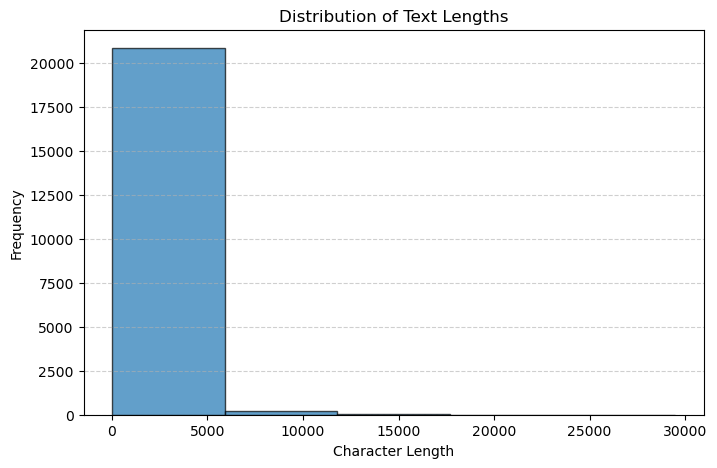

In [153]:
# Write your code here to visualise the data according to the 'Complaint' character length
import matplotlib.pyplot as plt

df_clean["complaint_text_length"] = df["complaint_text"].str.len()

plt.figure(figsize=(8, 5))
plt.hist(df_clean["complaint_text_length"], bins=5, edgecolor="black", alpha=0.7)
plt.xlabel("Character Length")
plt.ylabel("Frequency")
plt.title("Distribution of Text Lengths")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

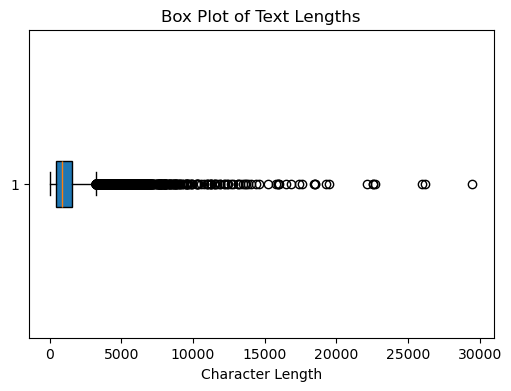

In [154]:
plt.figure(figsize=(6, 4))
plt.boxplot(df_clean["complaint_text_length"], vert=False, patch_artist=True)
plt.xlabel("Character Length")
plt.title("Box Plot of Text Lengths")
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [156]:
!pip install wordcloud

top_40_words={'I': 249307, 'the': 239149, 'be': 211987, 'to': 182057, 'and': 145528, 'my': 106625, 'a': 106417, 'have': 87734, 'that': 86822, 'chase': 80373, 'of': 79301, 'they': 72243, 'not': 67892, 'on': 62997, 'in': 62292, 'for': 55404, 'account': 48667, 'this': 47487, 'with': 43915, 'do': 40863, 'it': 38473, 'credit': 34145, 'card': 30517, 'from': 30356, 'bank': 28403, 'as': 26617, 'call': 26041, 'we': 23573, 'payment': 21167, 'would': 20753, 'at': 20389, 'tell': 19666, 'by': 18985, 'charge': 18229, 'an': 18197, 'receive': 17713, 'no': 17632, 'or': 17495, 'make': 17343, 'but': 17199}


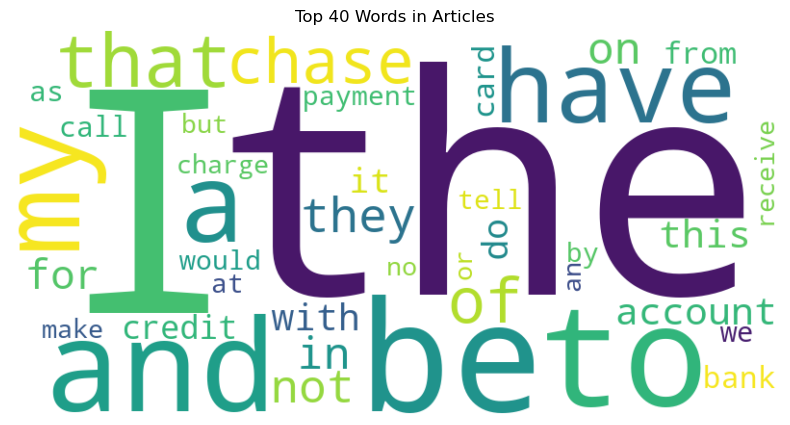

In [157]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from collections import Counter
from wordcloud import WordCloud

all_words = [word for text in df_clean["complaint_text_lemmatized"] for word in text.split()]
word_freq = Counter(all_words)
top_40_words = dict(word_freq.most_common(40))
print(f"top_40_words={top_40_words}")

wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate_from_frequencies(top_40_words)

# Display word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Top 40 Words in Articles")
plt.show()

In [158]:
#Removing -PRON- from the text corpus

df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')


/var/folders/cs/qyzc9w416ddcvcmlpws48d6m0000gn/T/ipykernel_87407/3150086778.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [160]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
all_words = [word for text in df_clean["Complaint_clean"] for word in text.split()]
word_freq = Counter(all_words)

top_30_unigrams = word_freq.most_common(30)



In [161]:
#Print the top 10 words in the unigram frequency

df_top_unigrams = pd.DataFrame(top_30_unigrams, columns=["Unigram", "Frequency"])
df_top_unigrams.head(10)

,Unigram,Frequency
0,chase,61760
1,account,41826
2,credit,32214
3,card,26675
4,bank,20495
5,payment,13955
6,time,11964
7,money,11939
8,loan,9950
9,information,9631


In [162]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
bigram_words = []

# Generate bigrams for each row separately
for text in df_clean["Complaint_clean"]:
    if isinstance(text, str):  # Ensure text is a string
        words = text.split()  # Tokenize the text
        bigrams = [" ".join((words[i], words[i+1])) for i in range(len(words)-1)]
        bigram_words.extend(bigrams)  # Collect bigrams from all rows

# Count bigram frequencies
bigram_word_freq = Counter(bigram_words)

# Get the top 30 most common bigrams
top_30_bigrams = bigram_word_freq.most_common(30)

In [163]:
#Print the top 10 words in the bigram frequency
df_top_bigrams = pd.DataFrame(top_30_bigrams, columns=["Bigram", "Frequency"])
df_top_bigrams.head(10)

,Bigram,Frequency
0,credit card,11060
1,chase bank,3968
2,account chase,3769
3,chase credit,3733
4,chase account,3637
5,credit report,3266
6,customer service,3021
7,account account,2989
8,checking account,2524
9,bank account,2499


In [164]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
trigram_words = []

# Generate trigrams for each row separately
for text in df_clean["Complaint_clean"]:
    if isinstance(text, str):  # Ensure text is a string
        words = text.split()  # Tokenize the text
        trigrams = [" ".join((words[i], words[i+1], words[i+2])) for i in range(len(words)-2)]
        trigram_words.extend(trigrams)  # Collect trigrams from all rows

# Count trigram frequencies
trigram_word_freq = Counter(trigram_words)

# Get the top 30 most common trigrams
top_30_trigrams = trigram_word_freq.most_common(30)

In [165]:
#Print the top 10 words in the trigram frequency
df_top_trigrams = pd.DataFrame(top_30_trigrams, columns=["Trigram", "Frequency"])
df_top_trigrams.head(10)

,Trigram,Frequency
0,chase credit card,2058
1,credit card chase,896
2,credit card account,859
3,credit card company,814
4,chase customer service,639
5,credit card credit,636
6,chase bank account,495
7,account chase account,465
8,card credit card,453
9,chase account chase,378


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [167]:
#df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [168]:
#All masked texts has been removed
#df_clean

This was already done as part of data cleaning

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [171]:
#Write your code here to initialise the TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words="english")


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [173]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
corpus = df_clean["Complaint_clean"].tolist() 
dtm = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(dtm.toarray(), columns=feature_names)
tfidf_df

,aa,aarp,abandonment,abatement,abbreviation,abide,ability,absence,absent,absurdity,...,yo,yoga,youth,yr,yrs,zilch,zip,zipcode,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.173044,0.0,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [175]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [177]:
#Load your nmf_model with the n_components i.e 5
# write the value you want to test out

#keep the random_state =40
num_topics = 5
nmf_model = NMF(n_components=num_topics, random_state=42)


In [178]:
W = nmf_model.fit_transform(dtm)  # Document-topic matrix
H = nmf_model.components_
len(feature_names)

5743

In [179]:
#Print the Top15 words for each of the topics

words = np.array(feature_names)
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,money,check,chase,checking,branch,deposit,number,business,fraud,transaction,claim,information,day
Topic 2,card,chase,credit,charge,dispute,fraud,company,merchant,fee,purchase,time,service,phone,letter,customer
Topic 3,loan,mortgage,chase,home,modification,property,foreclosure,letter,house,time,rate,sale,information,process,income
Topic 4,credit,report,inquiry,score,debt,reporting,account,information,limit,identity,bureaus,card,theft,company,history
Topic 5,payment,balance,month,statement,fee,date,auto,time,chase,day,error,car,history,account,transfer


In [180]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = W.argmax(axis=1) #write your code to assign topics to each rows.

/var/folders/cs/qyzc9w416ddcvcmlpws48d6m0000gn/T/ipykernel_87407/362795579.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [181]:
df_clean.head()

,complaint_text,complaint_text_lemmatized,complaint_POS_removed,complaint_text_length,Complaint_clean,Topic
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name be and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I be receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account thank in advance for your help,morning name stop debt verification statement bank debt mail month debt right information consumer chase account advance help,439,morning name stop debt verification statement bank debt mail month debt right information consumer chase account advance help,0
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,I upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account change my anniversary date from to without my consent have the recording of the agent who be mislead I,card agent anniversary date agent information order account anniversary date consent recording agent,296,card agent anniversary date agent information order account anniversary date consent recording agent,1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not credit without verify the identity of the applicant,chase card application identity consent identity applicant,202,chase card application identity consent identity applicant,1
11,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a ticket I come across an offer for to be apply towards

In [182]:
#Print the first 5 Complaint for each of the Topics
pd.set_option("display.max_colwidth", None)
df_agg=df_clean.groupby('Topic').head(5)
df_agg.sort_values('Topic')

,complaint_text,complaint_text_lemmatized,complaint_POS_removed,complaint_text_length,Complaint_clean,Topic
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name be and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I be receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account thank in advance for your help,morning name stop debt verification statement bank debt mail month debt right information consumer chase account advance help,439,morning name stop debt verification statement bank debt mail month debt right information consumer chase account advance help,0
24,mishandling of this account by chase auto and,mishandle of this account by chase auto and,account auto,45,account auto,0
17,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement ive been called and i was told that it may take two business day stating tuesday would be the date that my funds would be available to withdraw from a bank teller only now chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently unfortunately this has put me in an additional financial bind do two fees from late rent late car payments etc i am not being a short or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document i am not being a shored or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document this situation is truly affecting my livelihood and they dont seem to want to deal with me professionally thank you,with out notice jp morgan chase restrict my account by my debit card tuesday on thursday I go into a branch after be advise by a customer service representative that my account would actually be close I go into the branch to see how I can remove the fund that be in there currently in as well as if my direct deposit from my place of employment would be return the bank associate and the customer service representative assure I 

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

**Based on the Document Topic Matrix the Topic Names can be mapped to Topic numbers as below.**

In [185]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Mortgage/Loan',
    3: 'Theft/Dispute Reporting',
    4: 'Others'
}
df_clean["Topic"] = df_clean["Topic"].astype(int)
#Replace Topics with Topic Names
df_clean['Topic_Label'] = df_clean['Topic'].map(Topic_names)

/var/folders/cs/qyzc9w416ddcvcmlpws48d6m0000gn/T/ipykernel_87407/75664965.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/cs/qyzc9w416ddcvcmlpws48d6m0000gn/T/ipykernel_87407/75664965.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [186]:
df_clean.head(10)

,complaint_text,complaint_text_lemmatized,complaint_POS_removed,complaint_text_length,Complaint_clean,Topic,Topic_Label
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name be and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I be receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account thank in advance for your help,morning name stop debt verification statement bank debt mail month debt right information consumer chase account advance help,439,morning name stop debt verification statement bank debt mail month debt right information consumer chase account advance help,0,Bank Account services
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,I upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account change my anniversary date from to without my consent have the recording of the agent who be mislead I,card agent anniversary date agent information order account anniversary date consent recording agent,296,card agent anniversary date agent information order account anniversary date consent recording agent,1,Credit card or prepaid card
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not credit without verify the identity of the applicant,chase card application identity consent identity applicant,202,chase card application identity consent identity applicant,1,Credit card or prepaid card
11,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out o

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [188]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['complaint_text', 'Topic']]
print(len(training_data))
print(len(df_clean))

21072
21072


In [189]:
X = training_data["complaint_text"]  # Text data (customer complaints)
y = training_data["Topic"]  

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [191]:

#Write your code to get the Vector count
vect = TfidfVectorizer(max_df=0.95, min_df=2, stop_words="english")
X_tfidf = vect.fit_transform(X)

#Write your code here to transform the word vector to tf-idf

In [192]:
# Split train and test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

print("Length of X_train:", X_train.shape[0])
print("Length of X_test:", X_test.shape[0])


Length of X_train: 16857
Length of X_test: 4215


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

**Logistic Regression**

In [195]:
# Write your code here to build any 3 models and evaluate them using the required metrics

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [196]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on test set
y_pred_logreg = logreg.predict(X_test)

# Print evaluation metrics
print("📌 Logistic Regression Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_logreg))

📌 Logistic Regression Evaluation:
Accuracy: 0.9347568208778173

Confusion Matrix:
 [[1162   33    9    9    4]
 [  19 1176    6   13    2]
 [  17   22  677    6    2]
 [  12   33    8  536    4]
 [  25   31   13    7  389]]


**Decision Trees**

In [198]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)


DecisionTreeClassifier()

In [199]:
# Predict on test set
y_pred_dt = dt.predict(X_test)

# Print evaluation metrics
print("📌 Decision Tree Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))


📌 Decision Tree Evaluation:
Accuracy: 0.8365361803084223

Confusion Matrix:
 [[1045   88   28   23   33]
 [  66 1046   22   68   14]
 [  53   40  587   23   21]
 [  23   58   16  487    9]
 [  31   28   23   22  361]]


**Random Forests**

In [201]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [202]:
# Predict on test set
y_pred_rf = rf.predict(X_test)

# Print evaluation metrics
print("📌 Random Forest Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


📌 Random Forest Evaluation:
Accuracy: 0.8448398576512456

Confusion Matrix:
 [[1105   88    7    9    8]
 [  68 1109    3   33    3]
 [  42   18  643   15    6]
 [  23  101   13  451    5]
 [  74   77   47   14  253]]


**Naive Bayes**

In [204]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)


MultinomialNB()

In [205]:
# Predict on test set
y_pred_nb = nb.predict(X_test)

# Print evaluation metrics
print("📌 Naïve Bayes Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))


📌 Naïve Bayes Evaluation:
Accuracy: 0.726453143534994

Confusion Matrix:
 [[1043  141   18   15    0]
 [ 143 1036   10   26    1]
 [  57   42  610   15    0]
 [  50  205   31  303    4]
 [ 126  174   80   15   70]]


**Decision Trees with Hyperparameter Tuning**

In [207]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define hyperparameters to tune
param_grid_dt = {
    "max_depth": [5, 10, 20, None],  # Control tree depth
    "min_samples_split": [2, 5, 10],  # Minimum samples required to split a node
    "min_samples_leaf": [1, 2, 5]  # Minimum samples per leaf
}

# Initialize Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

# Apply GridSearchCV
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring="accuracy", n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

# Best parameters and best score
print("📌 Best Parameters for Decision Tree:", grid_search_dt.best_params_)
print("📌 Best Accuracy for Decision Tree:", grid_search_dt.best_score_)

# Train final model with best parameters
best_dt = grid_search_dt.best_estimator_


📌 Best Parameters for Decision Tree: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
📌 Best Accuracy for Decision Tree: 0.8344302970736726


**Random Forests with Hyperparameter Tuning**

In [209]:
from sklearn.ensemble import RandomForestClassifier

# Define hyperparameters to tune
param_grid_rf = {
    "n_estimators": [50, 100, 200],  
    "max_depth": [10, 20, 30], 
    "min_samples_split": [2, 5, 10], 
    "min_samples_leaf": [1, 2, 5] 
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Apply GridSearchCV
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring="accuracy", n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

print("📌 Best Parameters for Random Forest:", grid_search_rf.best_params_)
print("📌 Best Accuracy for Random Forest:", grid_search_rf.best_score_)

# Train final model with best parameters
best_rf = grid_search_rf.best_estimator_


📌 Best Parameters for Random Forest: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
📌 Best Accuracy for Random Forest: 0.8101669814371621


**Conclusion: The Logistic Regression model trained on Tf-Idf matrix has the best accuracy of around 93.5%.**

Predict new complaints based on the Logistic Regression model

In [283]:

new_complaints = [
    "My credit card was charged twice, but customer support is not helping!",
    "The loan officer gave misleading information about my interest rate.",
    "The loan application process was very confusing and took too long.",
    "I am getting unauthorized transactions on my bank account.",
    "The bank froze my account without notice, and I can’t access my money.",
    "Debt collectors are harassing me with calls even after I paid off my balance."
]

# Convert new complaints to TF-IDF features
new_complaints_tfidf = vect.transform(new_complaints)

predicted_topics = logreg.predict(new_complaints_tfidf)

df_predictions = pd.DataFrame({
    "Complaint": new_complaints,
    "Predicted_Topic": predicted_topics
})
df_predictions['Topic_Label'] = df_predictions['Predicted_Topic'].map(Topic_names)
df_predictions

,Complaint,Predicted_Topic,Topic_Label
0,"My credit card was charged twice, but customer support is not helping!",1,Credit card or prepaid card
1,The loan officer gave misleading information about my interest rate.,2,Mortgage/Loan
2,The loan application process was very confusing and took too long.,2,Mortgage/Loan
3,I am getting unauthorized transactions on my bank account.,0,Bank Account services
4,"The bank froze my account without notice, and I can’t access my money.",0,Bank Account services
5,Debt collectors are harassing me with calls even after I paid off my balance.,4,Others
